In [18]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from matplotlib.patches import Patch

### Load data

We load the SMK data + metadata in a couple of different formats:

df = Pandas DataFrame with SMK metadata on paintings (i.e., smk type "Maleri", "Akvarel", "Miniature" and "Gouache"). It's mainly "Maleri" in this category, though.

ds = HuggingFace dataset with same columns as pandas DF, but also a column storing a PIL image of the painting (mainly used here as it's easy to check the painting when it's stored in a ds)

In [3]:
# read df from csv 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'all_paintings_canonized.pkl'))

In [4]:
# load image data
ds = load_dataset("louisebrix/smk_all_paintings", split="train") # all the data is in the 'train' split

### Add image embeddings

Image embeddings are obtained by running the script 'smk_embeddings.py'. The pretrained model used is EVA-02-CLIP, a multimodal vision transformer architecture. The embeddings are saved as a .npy file in the /data folder.

In [5]:
# load embeddings
embeddings = np.load(os.path.join('..', 'data', 'eva02_clip_all_paintings.npy'))
embeddings.shape

(2085, 1024)

In [6]:
# need to convert to list to add to df
embeddings_list = list(embeddings)
df['embedding'] = embeddings_list

In [7]:
# make sure embeddings are still np arrays
print(type(df['embedding'].iloc[0]))
print(df['embedding'].iloc[0].shape)

<class 'numpy.ndarray'>
(1024,)


### Sanity check embeddings

Checking that our embeddings actually capture image content and style by running a kNN algorithm to find the nearest neighbors based on embeddings:

In [8]:
feature_list = np.array(df['embedding'].tolist())

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


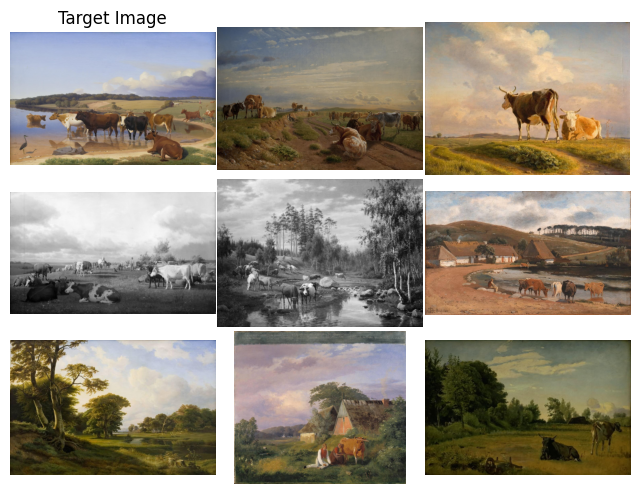

In [9]:
plot_neighbors(feature_list, 80, ds) # choose random image as target image

### Test Paper 1 workflow

In [27]:
type(df['on_display'].iloc[0])

numpy.int64

In [25]:
df['docs_canon'].replace({0: 'other', 1: 'canon'})

0       other
1       other
2       other
3       other
4       other
        ...  
2080    other
2081    other
2082    other
2083    other
2084    other
Name: docs_canon, Length: 2085, dtype: object

In [40]:
def pca_per_category(ax, df, canon_category, title):
    embeddings_array = np.array(df["embedding"].to_list(), dtype=np.float32)
    
    color_mapping = {'Other': '#129525', 'Canon': '#75BCC6'}

    column_mapped = df[canon_category].replace({0: 'Other', 1: 'Canon'})

    # to 2 dimensions
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(embeddings_array)
    df_pca = pd.DataFrame(pca_results, columns=["PCA1", "PCA2"])

    df_pca["canon"] = column_mapped.values

    alpha_dict = dict(zip(color_mapping.keys(), [0.65 if x != 'Other' else 0.2 for x in color_mapping.keys()]))

    # Plot each category
    for category in df_pca["canon"].unique():
        subset = df_pca[df_pca["canon"] == category]

        #marker = markers_dict.get(category) 
        alpha = alpha_dict.get(category)
        
        ax.scatter(
            subset["PCA1"],
            subset["PCA2"],
            color=color_mapping.get(category),
            label=category,
            alpha=alpha,
            edgecolor='black',
            s=110,
            marker='o' #marker
        )

    ax.set_title(title)
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")

    legend_handles = [Patch(facecolor=color, label=label) for label, color in color_mapping.items()]
    ax.legend(handles=legend_handles, loc='upper right')

    ax.axis("equal")

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

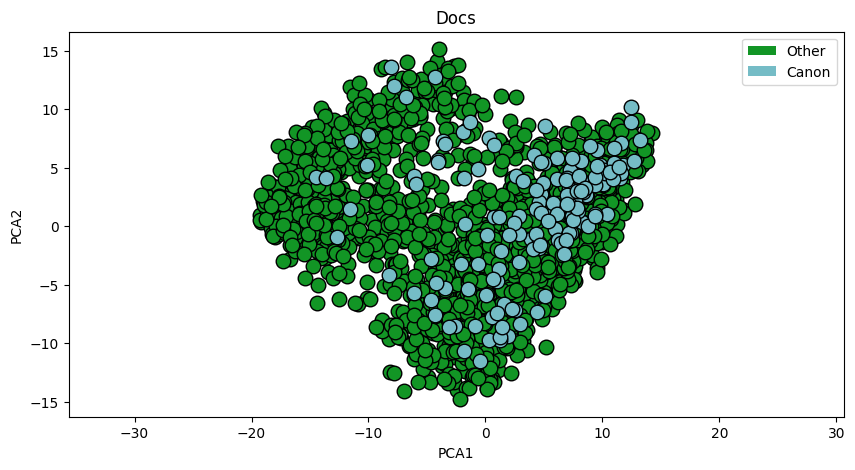

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
pca_per_category(axs, df, 'docs_canon', 'Docs')

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

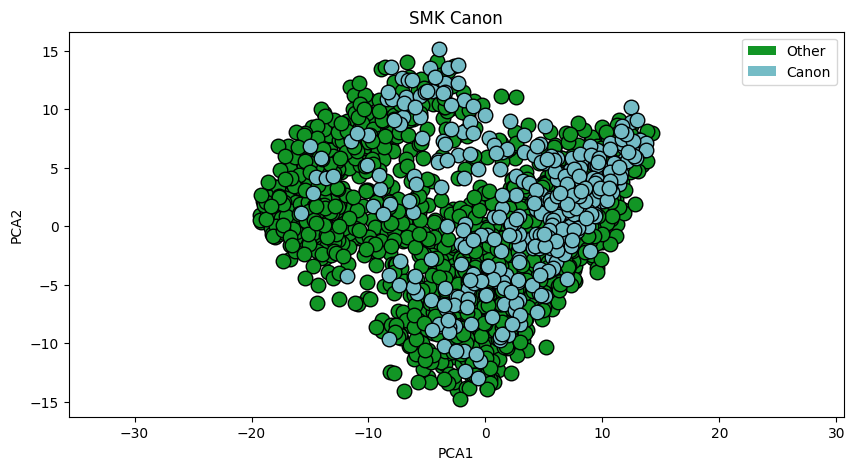

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
pca_per_category(axs, df, 'smk_exhibitions', 'SMK Canon')

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

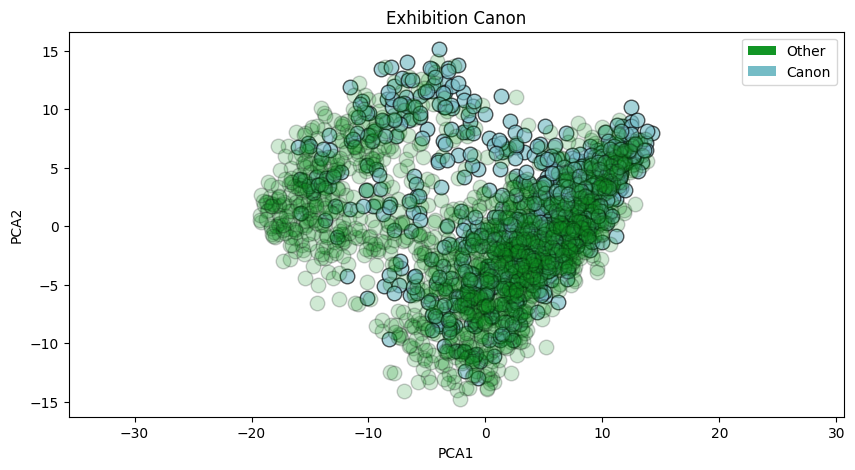

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
pca_per_category(axs, df, 'exb_canon', 'Exhibition Canon')

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

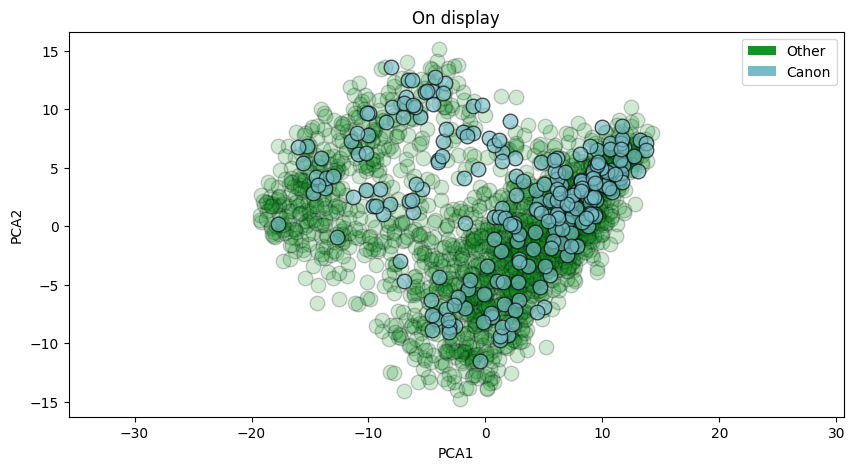

In [42]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
pca_per_category(axs, df, 'on_display', 'On display')

In [12]:
df.columns

Index(['smk_id', 'period', 'start_year', 'title', 'first_artist',
       'all_artists', 'num_artists', 'main_type', 'all_types',
       'image_thumbnail', 'gender', 'birth_death', 'nationality', 'history',
       'artist_roles', 'creator_roles', 'num_creators', 'techniques',
       'enrichment_url', 'content_person', 'has_text', 'colors',
       'geo_location', 'entropy', 'tags_en', 'image', 'rgb', 'exhibitions',
       'acquisition_date', 'responsible_department', 'documentation',
       'on_display', 'current_location_name', 'literary_reference',
       'object_history_note', 'exhibition_venues', 'smk_exhibitions',
       'golden_titles', 'exb_canon', 'docs_len', 'docs_canon', 'canon',
       'n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'embedding'],
      dtype='object')

In [14]:
#color_mapping = {'other': '#129525', 'on_display': '#356177', 'smk_exhibitions': '#FE7F2D', 'c_exb': '#9B7496', 'docs_canon': '#75BCC6'}#'#FCCA46'}
color_mapping = {'other': '#129525', 'canon': '#75BCC6'}

In [ ]:
subset = df.loc[df['category'] != 'O']

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/change_detection/env/lib/

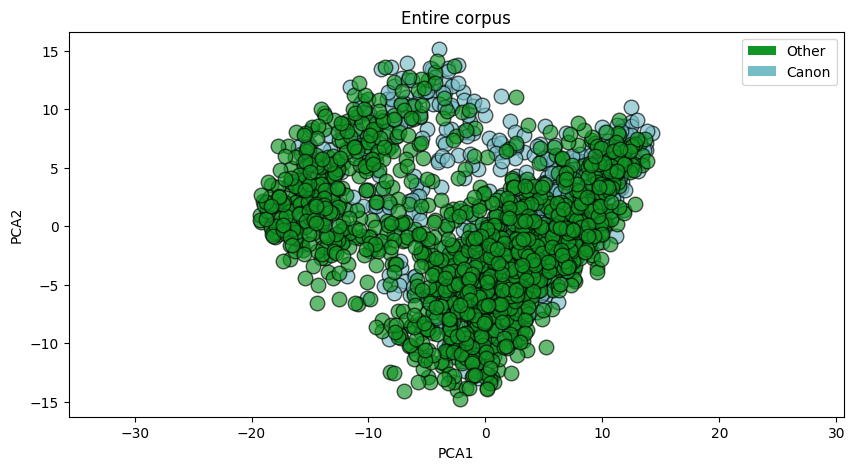

In [19]:
# PCA
# get colors
#color_mapping = {'smk_canon': '#129525', 'non_canon': '#356177'}#'#FCCA46'}

fig, axs = plt.subplots(1, 1, figsize=(10, 5))

plot_pca(axs, df, "Entire corpus", color_mapping)

In [ ]:
# PCA 2

### doesn't work with my years, need to do this differently !!! 

# # subsets of the first and last 15 years
sorted_df_year = df.sort_values(by='start_year', ascending=True)
# get the first 419 in a df and the last in another
df_first_15 = sorted_df_year.iloc[:1042]
df_last_15 = sorted_df_year.iloc[1042:]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Plot PCA for the entire dataset
plot_pca(axs[0], df_first_15, f"{df_first_15['start_year'].min()}-{df_first_15['start_year'].max()}, ($n$={len(df_first_15)})", color_mapping)
# Plot PCA for the subset
plot_pca(axs[1], df_last_15, f"{df_last_15['start_year'].min()}-{df_last_15['start_year'].max()} ($n$={len(df_last_15)})", color_mapping)
# layout
axs[1].legend().remove()
axs[1].set_ylabel("")
axs[0].legend(fontsize=9, loc='lower left')
# # # set x and y lims manually to the same scale
#xlims = [-0.075, 0.1]
#ylims = [-0.1, 0.075]
#axs[0].set_xlim(xlims)
#axs[0].set_ylim(ylims)
#axs[1].set_xlim(xlims)
#axs[1].set_ylim(ylims)
axs[0].set_title(f"{int(df_first_15['start_year'].min())}-{int(df_first_15['start_year'].max())}, ($n$={len(df_first_15)})", fontsize=13)
axs[1].set_title(f"{int(df_last_15['start_year'].min())}-{int(df_last_15['start_year'].max())}, ($n$={len(df_last_15)})", fontsize=13)
plt.tight_layout()
plt.show()

### Measure diachronic change (= variance in embeddings over time)

#### Naive approach (no up or downsampling)

In [ ]:
canon_df = df.query("canon == 'smk_canon'")

In [ ]:
canon_df

In [ ]:
## Start a loop over the years
mean_similarity_dict = {}

# window size and step size
window_size = 5
step_size = 1

# set sampling
sampling = False
sample_size = 4

# increase if we want to do more runs
number_of_runs = 1

# Get the minimum and maximum years in the dataset
min_year = df['start_year'].min()
max_year = df['start_year'].max()

In [ ]:
df['start_year'] = df['start_year'].astype(int)

In [ ]:
year_range = range(1800, 1810)
historical = df.loc[(df['start_year'].isin(year_range)) & (df['canon'] != 'smk_canon')]

In [ ]:
historical

In [ ]:
def get_cosim_mean_std(key):
    data = group_eb[key]
    embeddings = np.stack(data['embedding'].values)
    mean_cosim = cosine_similarity(embeddings).mean()
    std_cosim = cosine_similarity(embeddings).std()
    
    return mean_cosim, std_cosim

In [ ]:
for start_year in range(min_year, max_year - window_size + 1, step_size):

    temp = {}

    # Define rolling window range for each window
    year_range = list(range(start_year, start_year + window_size))
    range_label = f"{year_range[0]}-{year_range[-1]}"

    canon = df.loc[(df['start_year'].isin(year_range)) & (df['canon'] == 'smk_canon')]
    non_canon = df.loc[(df['start_year'].isin(year_range)) & (df['canon'] != 'smk_canon')]

    df_total = df.loc[df['start_year'].isin(year_range)]

    group_eb = {'canon': canon, 'non_canon': non_canon, 'df_total': df_total}

    if sampling == True:
    # sample from the groups

        for key in group_eb:
            group = group_eb[key]
            group_eb[key] = group.sample(sample_size, random_state=run) if len(group) > sample_size else group
    
    
    # get the mean embeddings of the current window for each group
    canon_mean = group_eb['canon']['embedding'].mean(axis=0)
    non_canon_mean = group_eb['non_canon']['embedding'].mean(axis=0)

    # get the cosine similarity btw canon and non-canon
    canon_noncanon_similarity = cosine_similarity(np.stack([non_canon_mean, canon_mean])).mean()
    temp['CANON_NONCANON_COSIM'] = canon_noncanon_similarity

    # save
    #mean_similarity_dict[range_label] = temp

    # get canon embeddings
    canon_mean, canon_std = get_cosim_mean_std('canon')
    temp['CANON_COSIM_MEAN'] = canon_mean 
    temp['CANON_COSIM_STD'] = canon_std

    nc_mean, nc_std = get_cosim_mean_std('non_canon')
    temp['NONCANON_COSIM_MEAN'] = nc_mean
    temp['NONCANON_COSIM_STD'] = nc_std

    t_mean, t_std = get_cosim_mean_std('df_total')
    temp['TOTAL_COSIM_MEAN'] = t_mean
    temp['TOTAL_COSIM_STD'] = t_std

    temp['n_paintings'] = [len(df_total), len(canon), len(non_canon)]
    mean_similarity_dict[range_label] = temp

# Format df
sim_df = pd.DataFrame.from_dict(mean_similarity_dict, orient='index').reset_index()
sim_df = sim_df.rename(columns={"index": "year_RANGE"})

sim_df['START_year'] = sim_df['year_RANGE'].apply(lambda x: int(x.split('-')[0]))
    

    #windows_list.append(temp)


In [ ]:
sim_df

In [ ]:
plt.plot(sim_df['START_year'], sim_df['CANON_NONCANON_COSIM'], color='#75BCC6', linewidth=2, 
             alpha=0.3)
plt.title("Canon vs Non-Canon Cosine Similarity Over Time")

In [ ]:
plt.plot(sim_df['START_year'], sim_df['NONCANON_COSIM_MEAN'])

In [ ]:
plt.plot(sim_df['START_year'], sim_df['CANON_COSIM_MEAN'])

In [ ]:
df.query('smk_exhibitions == True')

#### Inter-group similarity

we want to see if the difference btw canon and noncanon decreases over time